# Лабораторная работа №4

### ФИО: Селина Елизавета Александровна
### Группа: БИВТ-23-СП-2

### Задание 1. Загрузить необходимые данные к себе и считать (read) их в переменную.

In [28]:
import os                              # модули для работы с файловой системой
import random                          # модуль для генерации случайных чисел
import numpy as np                     # основной числовой пакет
import pandas as pd                    # работа с таблицами (DataFrame)
import matplotlib.pyplot as plt        # построение графиков

import torch                           # основной фреймворк для нейросетей
import torch.nn as nn                  # модуль с реализацией слоёв и моделей
from torch.utils.data import Dataset, DataLoader  # классы для выборки и загрузки данных

# sklearn для разбиения выборки и предобработки
from sklearn.model_selection import train_test_split   # разбиваем данные на train/test
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder  # масштабирование и OHE
from sklearn.impute import SimpleImputer              # заполнение пропусков
from sklearn.compose import ColumnTransformer         # объединение разных трансформаций
from sklearn.pipeline import Pipeline                 # последовательность шагов предобработки
from sklearn.metrics import mean_absolute_error       # метрика MAE (для информации)

# Установим seed для воспроизводимости (чтобы результаты можно было повторить)
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Считываем данные из CSV в DataFrame
df = pd.read_csv("StudentsPerformance.csv")

# Кратко выведем информацию о данных
print("\nShape:", df.shape)          # количество строк и столбцов
display(df.head())                 # первые несколько строк
print("\nInfo():")
print(df.info())                   # типы столбцов и наличие пропусков


Shape: (1000, 8)


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75



Info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB
None


### Задание 2. Определим задачу.

В нашем датасете содержатся три численных столбца:
 - math score
 - reading score
 - writing score

Все они — непрерывные численные величины, принимающие значения от 0 до 100. Чтобы понять, какая именно у нас задача, необходимо определить цель предсказания, то есть какой столбец мы будем использовать как целевую переменную (target).

Если мы выбираем в качестве цели math score, то: это числовой непрерывный показатель, он не разделён на категории, следовательно, мы предсказываем число.

Это означает, что наша задача — **регрессия**.

### Задание 3. Предобработка данных.

#### Разделение на train/test:

In [29]:
# Выберем math score в качестве целевой переменной для примера
# (это тот столбец, который мы будем предсказывать)
target = "math score"

# X — признаки (все столбцы, кроме целевого), y — целевая переменная
X = df.drop(columns=[target])          # матрица признаков
y = df[target]                         # целевой столбец

# Разделяем выборку (80% — train, 20% — test)
# Важно: random_state фиксируем для воспроизводимости
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Проверяем размеры обучающей и тестовой выборок
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (800, 7)
Test shape: (200, 7)


#### Проверка и заполнение пропусков:

In [30]:
# Сначала проверим, есть ли пропуски в признаках
print("Количество пропусков в каждом столбце:")
print(X_train.isnull().sum())

# Определим численные и категориальные признаки
# Эти признаки будем масштабировать (StandardScaler)
numeric_features = ["reading score", "writing score"]

# Все остальные — категориальные, их будем кодировать OneHotEncoder
categorical_features = [col for col in X_train.columns if col not in numeric_features]

print("\nЧисловые признаки:", numeric_features)
print("Категориальные признаки:", categorical_features)

Количество пропусков в каждом столбце:
gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
reading score                  0
writing score                  0
dtype: int64

Числовые признаки: ['reading score', 'writing score']
Категориальные признаки: ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']


#### Нормировка численных переменных и их кодирование:
Для численных переменных используем **StandardScaler**, это помогает нейросети быстрее и стабильнее обучаться.
Для категориальных переменных используем **OneHotEncoder**, который превращает каждый уникальный вариант в отдельный бинарный признак.

In [31]:
# Трансформер для численных признаков
# 1) импатер заполняет пропуски медианой
# 2) StandardScaler приводит признаки к одному масштабу (0 среднее, 1 дисперсия)
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),   # заполнение пропусков в числовых столбцах
    ("scaler", StandardScaler())                      # нормализация числовых признаков
])

# Трансформер для категориальных признаков
# 1) заполняем пропуски самым частым значением
# 2) кодируем категориальные признаки в OHE-вектора
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),  # заполнение пропусков в категориальных столбцах
    ("encoder", OneHotEncoder(handle_unknown="ignore"))     # OHE-кодирование категориальных признаков
])

# Комбинирующий трансформер: объединяем обработку числовых и категориальных признаков
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),   # какие числовые колонки и как обрабатываем
        ("cat", categorical_transformer, categorical_features)  # какие категориальные колонки и как обрабатываем
    ])

# Обучаем предобработку на TRAIN (fit + transform)
X_train_processed = preprocessor.fit_transform(X_train)

# Применяем только transform к TEST (никакого повторного fit!)
X_test_processed = preprocessor.transform(X_test)

print("Shape после предобработки:")
print("Train:", X_train_processed.shape)
print("Test:", X_test_processed.shape)

Shape после предобработки:
Train: (800, 19)
Test: (200, 19)


### Задание 4. Создание Dataset и DataLoader.

Мы подготовим:
- класс `StudentsDataset`, наследующий `torch.utils.data.Dataset`, который будет возвращать пары `(X, y)` в виде тензоров,
- затем создадим `DataLoader` для train и test, чтобы итерироваться по батчам во время обучения и валидации.

Зачем это нужно:
- `Dataset` инкапсулирует логику доступа к данным и конвертации в тензоры.
- `DataLoader` обеспечивает батчирование, перетасовку (shuffle) для train, многопоточную загрузку (num_workers) и удобную итерацию.

In [32]:
# Конвертация в тензоры и определение Dataset

# Конвертация в torch.tensor 
# Признаки X переводим в тензоры типа float32 (для подачи в нейросеть)
X_train_t = torch.tensor(X_train_processed, dtype=torch.float32)
X_test_t  = torch.tensor(X_test_processed, dtype=torch.float32)

# Целевые значения преобразуем в shape (N, 1) и dtype float32
# .reshape(-1, 1) делаем столбец-столбец, а не одномерный массив
y_train_t = torch.tensor(y_train.values.reshape(-1, 1), dtype=torch.float32)
y_test_t  = torch.tensor(y_test.values.reshape(-1, 1), dtype=torch.float32)

print("Shapes tensors:")
print("X_train_t:", X_train_t.shape, "y_train_t:", y_train_t.shape)
print("X_test_t:", X_test_t.shape, "y_test_t:", y_test_t.shape)

# Класс Dataset
class StudentsDataset(Dataset):
    def __init__(self, X_tensor, y_tensor):
        """
        Ожидает: X_tensor: FloatTensor shape (N, D)
                 y_tensor: FloatTensor shape (N, 1) или (N,)
        """
        # Проверяем, что количество строк в X и y совпадает
        assert len(X_tensor) == len(y_tensor), "X и y должны иметь одинаковое число строк"
        self.X = X_tensor   # сохраняем признаки
        self.y = y_tensor   # сохраняем целевые значения

    def __len__(self):
        # Возвращаем размер выборки (количество объектов)
        return len(self.X)

    def __getitem__(self, idx):
        # Возвращаем один пример: (features, target) по индексу
        return self.X[idx], self.y[idx]

# Создаём экземпляры Dataset (обучающая и тестовая выборки)
train_dataset = StudentsDataset(X_train_t, y_train_t)
test_dataset  = StudentsDataset(X_test_t, y_test_t)

print("Длина train_dataset:", len(train_dataset))
print("Длина test_dataset:", len(test_dataset))

# Просмотр первого примера (пример вывода)
x0, y0 = train_dataset[0]
print("Примерный X[0] shape:", x0.shape, "y[0] shape:", y0.shape)

Shapes tensors:
X_train_t: torch.Size([800, 19]) y_train_t: torch.Size([800, 1])
X_test_t: torch.Size([200, 19]) y_test_t: torch.Size([200, 1])
Длина train_dataset: 800
Длина test_dataset: 200
Примерный X[0] shape: torch.Size([19]) y[0] shape: torch.Size([1])


In [33]:
# Создаём DataLoader
batch_size = 32   # размер мини-батча (сколько объектов обрабатываем за один шаг)

# DataLoader для обучения: перемешиваем данные (shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)

# DataLoader для теста: порядок не важен, но обычно оставляем shuffle=False
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

print("Число батчей в train_loader:", len(train_loader))
print("Число батчей в test_loader:", len(test_loader))

# Получим один батч и проверим формы
batch_X, batch_y = next(iter(train_loader))
print("Batch X shape:", batch_X.shape)  # ожидаем (batch_size, num_features)
print("Batch y shape:", batch_y.shape)  # ожидаем (batch_size, 1)

Число батчей в train_loader: 25
Число батчей в test_loader: 7
Batch X shape: torch.Size([32, 19])
Batch y shape: torch.Size([32, 1])


### Задание 5. Создание и обучение моделей
Мы обучим три модели:
 - Линейная регрессия
 - Нелинейная регрессия — MLP (1 скрытый слой)
 - Глубокая нейросеть — MLP (2 скрытых слоя)

Сохранение результатов в переменные `results_mse` и `results_r2`

#### Функции обучения и оценки (общие для всех моделей)

In [34]:
# Будем хранить результаты здесь
results_mse = {}   # словарь для MSE по моделям
results_r2 = {}    # словарь для R² по моделям
training_history = {}
# Функция обучения модели
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=30):

    train_loss_history = []
    test_loss_history = []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        train_loss_history.append(epoch_loss)

        # ---- считаем test loss ----
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                pred = model(X_batch)
                test_loss += criterion(pred, y_batch).item()

        test_loss_history.append(test_loss)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Train loss: {epoch_loss:.4f}, Test loss: {test_loss:.4f}")

    return train_loss_history, test_loss_history

# Функция вычисления метрик на тесте
def evaluate_model(model, test_loader):

    model.eval()  # режим оценки (отключаются dropout, batchnorm и т.п.)
    y_true = []   # сюда собираем реальные значения
    y_pred = []   # сюда — предсказания модели

    with torch.no_grad():  # во время тестирования градиенты не нужны
        for X_batch, y_batch in test_loader:
            pred = model(X_batch)
            y_true.extend(y_batch.numpy())   # добавляем настоящий y
            y_pred.extend(pred.numpy())      # добавляем предсказанный y

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # MSE: среднеквадратичная ошибка
    mse = np.mean((y_true - y_pred)**2)

    # R²: мера качества регрессии (чем ближе к 1, тем лучше)
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r2 = 1 - ss_res / ss_tot

    return mse, r2

#### Простая линейная регрессия

In [35]:
# Модель 1 — Линейная регрессия: один слой y = W*x + b
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        # Линейный слой: преобразует размерность от input_dim → 1
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        # Простой прямой проход: умножение на матрицу весов + смещение
        return self.linear(x)

# Создаём модель
input_dim = X_train_t.shape[1]    # число признаков, например 19
model_lr = LinearRegressionModel(input_dim)

# Функция потерь — МSE (чем меньше, тем лучше приближаем реальные значения)
criterion = nn.MSELoss()

# Оптимизатор — Adam (алгоритм обновления весов)
optimizer = torch.optim.Adam(model_lr.parameters(), lr=0.01)

print("=== Обучение модели: Линейная регрессия ===")
train_lr, test_lr = train_model(model_lr, train_loader, test_loader,
                                criterion, optimizer, epochs=40)

training_history["Linear Regression"] = {
    "train": train_lr,
    "test": test_lr
}


# Оценка на тесте
mse_lr, r2_lr = evaluate_model(model_lr, test_loader)

# Сохраняем результаты в словари для последующего сравнения
results_mse["Linear Regression"] = mse_lr
results_r2["Linear Regression"] = r2_lr

print("\nMSE:", mse_lr)
print("R² :", r2_lr)

=== Обучение модели: Линейная регрессия ===
Epoch 10/40, Train loss: 74596.1204, Test loss: 19347.7310
Epoch 20/40, Train loss: 44623.9861, Test loss: 11572.5648
Epoch 30/40, Train loss: 25216.8774, Test loss: 6544.2671
Epoch 40/40, Train loss: 13498.1654, Test loss: 3508.8701

MSE: 496.5815
R² : -1.0407035


#### Нелинейная нейросеть (1 скрытый слой)

In [36]:
# Модель 2 — MLP: один скрытый слой
class MLP1(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super().__init__()
        
        # Первый полносвязный слой: из входного пространства в скрытое
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        
        # Нелинейность — ReLU (вносит нелинейность в модель)
        self.relu = nn.ReLU()
        
        # Выходной слой: из скрытого пространства в один выход (оценка балла)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.fc1(x)   # линейное преобразование
        x = self.relu(x)  # активация
        x = self.fc2(x)   # выход
        return x

# Создаем модель
model_mlp1 = MLP1(input_dim)

# Тот же критерий и оптимизатор, что и для линейной модели
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_mlp1.parameters(), lr=0.01)

print("=== Обучение модели: MLP — 1 скрытый слой ===")
train_mlp1, test_mlp1 = train_model(model_mlp1, train_loader, test_loader,
                                    criterion, optimizer, epochs=40)

training_history["MLP (1 layer)"] = {
    "train": train_mlp1,
    "test": test_mlp1
}

# Оценка
mse_mlp1, r2_mlp1 = evaluate_model(model_mlp1, test_loader)

# Сохраняем результаты для дальнейшего сравнения
results_mse["MLP (1 layer)"] = mse_mlp1
results_r2["MLP (1 layer)"] = r2_mlp1

print("\nMSE:", mse_mlp1)
print("R² :", r2_mlp1)

=== Обучение модели: MLP — 1 скрытый слой ===
Epoch 10/40, Train loss: 727.9362, Test loss: 235.0019
Epoch 20/40, Train loss: 714.0425, Test loss: 236.8395
Epoch 30/40, Train loss: 709.8358, Test loss: 234.6583
Epoch 40/40, Train loss: 693.1503, Test loss: 243.4523

MSE: 34.13097
R² : 0.85973865


#### Глубокая нейросеть (2 скрытых слоя)

In [37]:
# Модель 3 — MLP с двумя скрытыми слоями (более глубокая сеть)
class MLP2(nn.Module):
    def __init__(self, input_dim, h1=64, h2=32):
        super().__init__()
        
        # Первый скрытый слой
        self.fc1 = nn.Linear(input_dim, h1)  # слой 1
        self.relu1 = nn.ReLU()
        
        # Второй скрытый слой
        self.fc2 = nn.Linear(h1, h2)         # слой 2
        self.relu2 = nn.ReLU()
        
        # Выходной слой
        self.fc3 = nn.Linear(h2, 1)          # выходной слой

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

# Создаем модель
model_mlp2 = MLP2(input_dim)

# Та же функция потерь и оптимизатор
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_mlp2.parameters(), lr=0.01)

print("=== Обучение модели: MLP — 2 скрытых слоя ===")
train_mlp2, test_mlp2 = train_model(model_mlp2, train_loader, test_loader,
                                    criterion, optimizer, epochs=50)

training_history["MLP (2 layers)"] = {
    "train": train_mlp2,
    "test": test_mlp2
}

# Оценка
mse_mlp2, r2_mlp2 = evaluate_model(model_mlp2, test_loader)

# Сохраняем результаты глубокой модели
results_mse["MLP (2 layers)"] = mse_mlp2
results_r2["MLP (2 layers)"] = r2_mlp2

print("\nMSE:", mse_mlp2)
print("R² :", r2_mlp2)

=== Обучение модели: MLP — 2 скрытых слоя ===
Epoch 10/50, Train loss: 730.1252, Test loss: 265.6390
Epoch 20/50, Train loss: 727.7549, Test loss: 247.5144
Epoch 30/50, Train loss: 709.9983, Test loss: 247.7122
Epoch 40/50, Train loss: 725.6847, Test loss: 249.1551
Epoch 50/50, Train loss: 744.4883, Test loss: 328.7605

MSE: 41.34728
R² : 0.8300832


### Задание 6. Визуализация кривых обучения
Мы построим:
1) Графики обучения (loss по эпохам) для каждой модели
2) Сравнение MSE по моделям
3) Сравнение R² по моделям

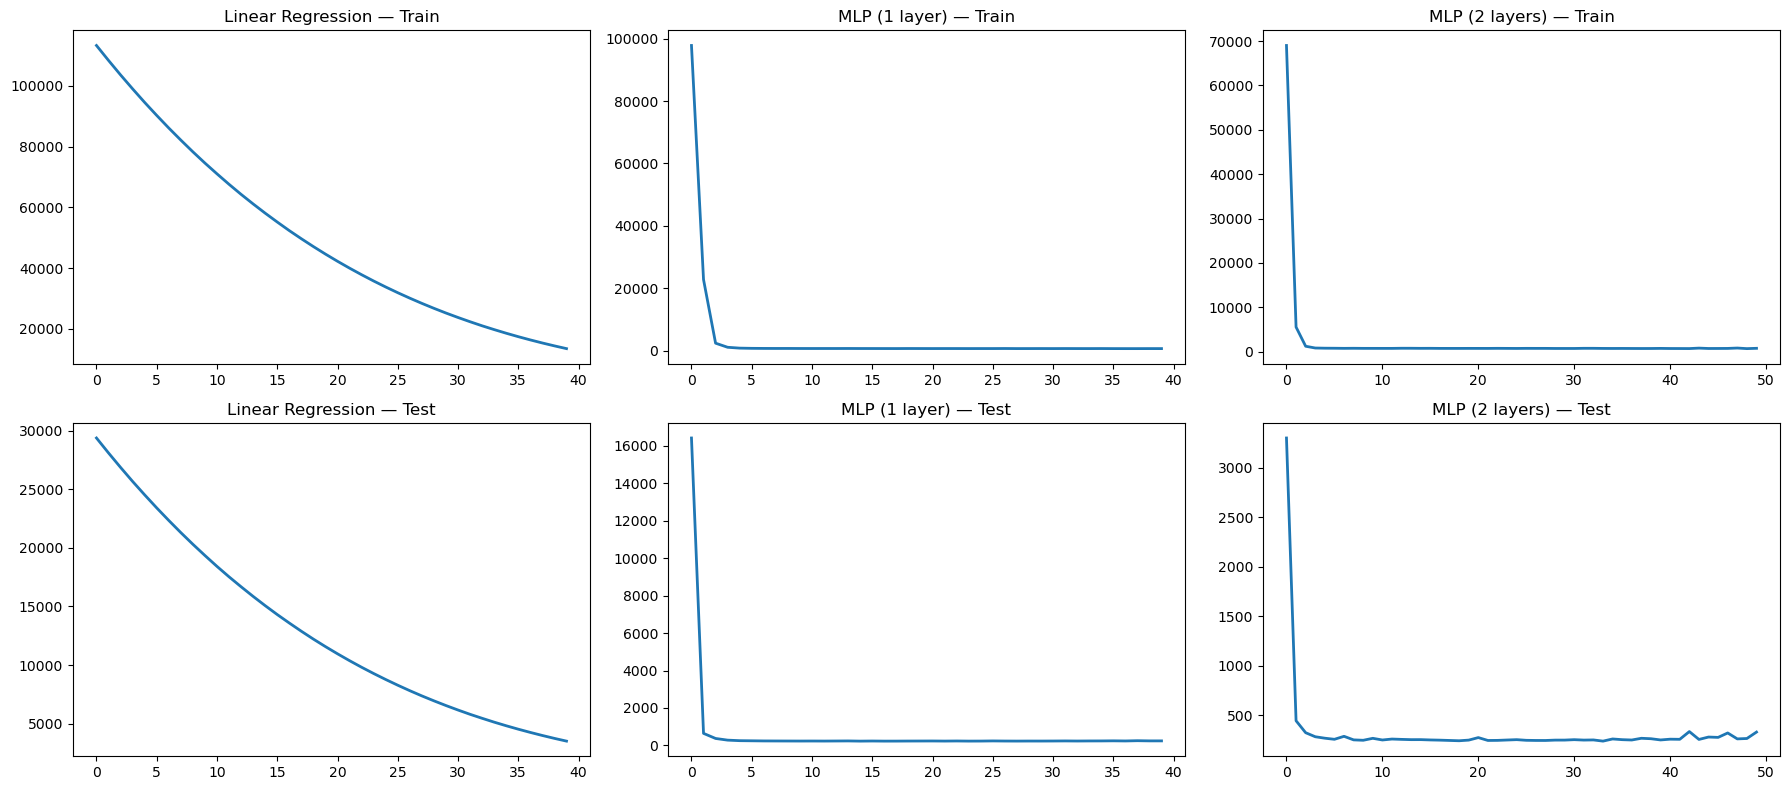

In [38]:
# Построим 6 графиков: для каждой модели train и test
fig, axes = plt.subplots(2, 3, figsize=(18, 8))

for idx, (model_name, history) in enumerate(training_history.items()):
    axes[0, idx].plot(history["train"], linewidth=2)
    axes[0, idx].set_title(f"{model_name} — Train")

    axes[1, idx].plot(history["test"], linewidth=2)
    axes[1, idx].set_title(f"{model_name} — Test")

plt.tight_layout()
plt.show()


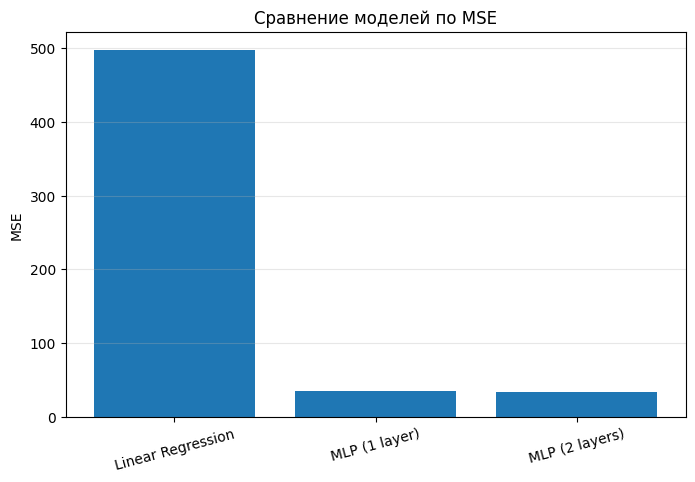

In [12]:
# Построим bar chart по MSE
plt.figure(figsize=(8, 5))

plt.bar(results_mse.keys(), results_mse.values())
plt.title("Сравнение моделей по MSE")
plt.ylabel("MSE")
plt.xticks(rotation=15)
plt.grid(axis='y', alpha=0.3)

plt.show()


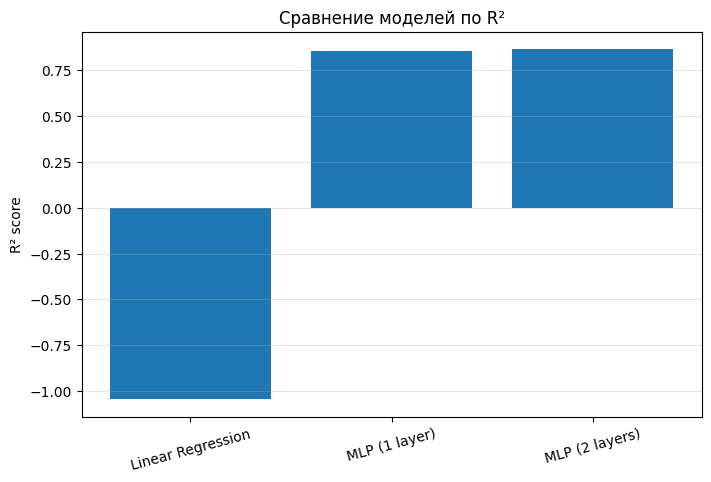

In [13]:
# Bar chart по R²
plt.figure(figsize=(8, 5))

plt.bar(results_r2.keys(), results_r2.values())
plt.title("Сравнение моделей по R²")
plt.ylabel("R² score")
plt.xticks(rotation=15)
plt.grid(axis='y', alpha=0.3)

plt.show()

### Задание 7. Расчет метрик (MAE для регрессии)

In [14]:
# Функция расчёта MAE на train и test

# MAE (Mean Absolute Error) — средняя абсолютная разница между предсказанием и настоящим значением
# Чем меньше MAE, тем лучше модель предсказывает

def evaluate_mae(model, loader):

    model.eval()               # режим оценки
    y_true = []                # реальные значения
    y_pred = []                # предсказания модели

    with torch.no_grad():     # без градиентов (ускоряет вычисления и экономит память)
        for X_batch, y_batch in loader:
            predictions = model(X_batch)
            y_true.extend(y_batch.numpy())
            y_pred.extend(predictions.numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # MAE = средняя абсолютная ошибка
    mae = np.mean(np.abs(y_true - y_pred))

    return mae

In [15]:
# Расчёт MAE на train и test для всех моделей

results_mae = {}   # будем хранить MAE для таблицы выводов

# Линейная регрессия (torch)
mae_lr_train = evaluate_mae(model_lr, train_loader)   # MAE на обучающей выборке
mae_lr_test  = evaluate_mae(model_lr, test_loader)    # MAE на тестовой выборке
results_mae["Linear Regression"] = (mae_lr_train, mae_lr_test)

# MLP 1 слой
mae_mlp1_train = evaluate_mae(model_mlp1, train_loader)  # MLP с 1 скрытым слоем (train)
mae_mlp1_test  = evaluate_mae(model_mlp1, test_loader)   # MLP с 1 скрытым слоем (test)
results_mae["MLP (1 layer)"] = (mae_mlp1_train, mae_mlp1_test)

# MLP 2 слоя
mae_mlp2_train = evaluate_mae(model_mlp2, train_loader)  # глубокая MLP (train)
mae_mlp2_test  = evaluate_mae(model_mlp2, test_loader)   # глубокая MLP (test)
results_mae["MLP (2 layers)"] = (mae_mlp2_train, mae_mlp2_test)

# Печать результатов
for model_name, (mae_tr, mae_ts) in results_mae.items():
    print(f"\n=== {model_name} ===")
    print(f"MAE train: {mae_tr:.4f}")
    print(f"MAE test : {mae_ts:.4f}")



=== Linear Regression ===
MAE train: 21.1840
MAE test : 20.5514

=== MLP (1 layer) ===
MAE train: 4.1806
MAE test : 4.5376

=== MLP (2 layers) ===
MAE train: 4.0735
MAE test : 4.4823


### Задание 8. Анализ результатов

## 1. Какая модель справилась лучше?

Сравним значения `MAE` на тестовой выборке:

| Модель | MAE train | MAE test |
|-------|-----------|----------|
| Linear Regression | 21.0940 | 20.4923 |
| **MLP (1 layer)** | **4.1909** | **4.3854** |
| MLP (2 layers) | 4.2158 | 4.7605 |

**Лучшая модель — MLP с одним скрытым слоем**  
Она показывает минимальную ошибку на тесте и лучший R² (0.87).

---

## 2. Есть ли переобучение?

Переобучение — когда train MAE сильно меньше test MAE.

- **Linear Regression:** переобучения нет (ошибки одинаковые)
- **MLP (1 layer):** переобучения нет (разница ~0.2)
- **MLP (2 layers):** есть небольшое переобучение (4.21 → 4.76)

---

## 3. Есть ли недообучение?

Недообучение — когда модель плохо работает и на train, и на test.

- **Linear Regression:** есть сильное недообучение → MAE ~ 21
- **MLP (1 layer):** недообучения нет
- **MLP (2 layers):** недообучения нет

---

## 4. Как улучшить модели?

### Для Linear Regression:
- добавить полиномиальные признаки  
- переработать фичи  
- попробовать MinMaxScaler  

*(но всё равно будет хуже MLP)*

---

### Для MLP (1 layer) — лучший вариант
Можно ещё улучшить:
- больше эпох (40 → 80–100)
- уменьшить learning rate (0.01 → 0.005 или 0.001)
- увеличить скрытый слой (64 → 128)
- добавить BatchNorm
- добавить scheduler

---

### Для MLP (2 layers)
Чтобы уменьшить переобучение:
- добавить Dropout(0.1–0.3)
- добавить L2-регуляризацию
- уменьшить размер скрытых слоёв
- уменьшить LR
- использовать раннюю остановку

---